## MIE1624 Assignment 1

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker
try:
    import seaborn as sns
except:
    !pip install seaborn

# Libraries for text cleaning
import html
import re
import string

# Libraries for word cloud
try:
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
except:
    ! pip install wordcloud
    
# Libraries for text analytics
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

/Users/angela/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Cleaning

#### Prepares the Twitter data for analysis 

In [2]:
def text_process(df):
    '''
    The procedure that cleans the twitter data by:
    1. Replacing HTML character codes witht their ASCII equivalents
    2. Removing all HTML tags
    3. Removing all URLs
    4. Transforming all characters into lowercase
    5. Removing stopwords
    
    Returns the processed data frame
    '''
    
    # Replace HTML character codes
    df['text'] = df['text'].apply(lambda x: html.unescape(x))
    
    # Remove HTML tags
    html_tag = r'<[^>]+>'
    df['text'] = df['text'].replace(html_tag, ' ', regex=True)
    
    # Remove URLs
    url_tags = [r'http\S+',
           r'\S+\.ca\S+',
           r'\S+\.com\S+',
           r'\S+\.net\S+',
           r'\S+\.me\S+',
           r'\S+\.co\.uk\S+',
           r'\S+\.it\S+',
           r'\S+\.ly\S+',
           r'\S+\.to\S+',
           r'\S+.html']
    for i in range(len(url_tags)):
        df['text'] = df['text'].replace(url_tags[i], ' ', regex=True)
        
    # Convert uppercase to lowercase
    df['text'] = df['text'].apply(lambda x: str(x).lower())
    
    # Remove stopwords
    stop_words = pd.read_table('stop_words.txt', names=['word']).values.tolist()
    stop_words = np.reshape(stop_words, [1, len(stop_words)])

    df['splitted_words'] = df['text'].apply(lambda x: x.split()) # Did not use nltk tokenize() because it separates the hashtag and #

    #f2 = lambda x: ' '.join([w for w in x if not w in stop_words])
    f2 = lambda x: [w for w in x if not w in stop_words]
    df['stripped_text'] = df['splitted_words'].map(f2)
    
    return df

In [3]:
# Prepare unclassified tweets
unclassified = pd.read_table('unclassified_tweets.txt', names=['text'])
unclassified = text_process(unclassified)

In [4]:
# Prepare classified tweets
classified = pd.read_csv('classified_tweets.txt')
classified = text_process(classified)
classified.head()

,class,id,date,query,user,text,splitted_words,stripped_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot - awww, that's a bummer. you sh...","[@switchfoot, -, awww,, that's, a, bummer., yo...","[@switchfoot, -, awww,, that's, bummer., shoul..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...,"[is, upset, that, he, can't, update, his, face...","[upset, update, facebook, texting, it..., cry,..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...,"[@kenichan, i, dived, many, times, for, the, b...","[@kenichan, dived, times, ball., managed, save..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[body, feels, itchy, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","[@nationwideclass, no,, it's, not, behaving, a...","[@nationwideclass, no,, it's, behaving, all., ..."


### 2. Exploratory Analysis

#### Determine the political party for all tweets.

In [5]:
def f3(x):
    '''
    The procedure that takes out the hashtag of a tweet
    '''
    result = []
    for w in x:
        if w.startswith('#'):
            result.append(w.replace('#', ''))
    return result
unclassified['hashtag'] = unclassified['stripped_text'].apply(f3)

In [6]:
def f4(x):
    '''
    The procedure that eliminates # and @
    '''
    result = []
    for w in x:
        result.append(w.replace('#', '').replace('@', ''))
    return result
unclassified['stripped_text'] = unclassified['stripped_text'].apply(f4)

In [7]:
# Eliminate punctuations
def f5(x):
    result = []
    map = str.maketrans('', '', string.punctuation)
    for w in x:
        result.append(w.translate(map).replace('…', ' '))
    return result
unclassified['stripped_text'] = unclassified['stripped_text'].apply(f5)

In [8]:
# Identify the political party
liberal = ['justin', 'justins', 'trudeau', 'trudeaus', 'justintrudeau', 'justintrudeaus', 'teamtrudeau', 'generationtrudeau', 'liberal', 'liberals', 'liberalparty', 'lpc']
conservative = ['stephen', 'harper', 'harpers', 'stephenharper', 'pmharper', 'conservative', 'conservatives', 'cpc']
new_democratic = ['tom', 'mulcair', 'tommulcair', 'thomasmulcair', 'tommulcair’s', 'new democratic', 'ndp']

def f6(x):
    for w in x:
        if w in liberal:
            return 'liberal'
        if w in conservative:
            return 'conservative'
        if w in new_democratic:
            return 'new democratic'
    return 'others'
    
# Use stripped text instead of hashtag because a lot of the key words are mentioned in plain text and mentions
unclassified['political_party'] = unclassified['stripped_text'].apply(f6)

In [9]:
# Tweets that cannot be classified into the three main parties
unclassified[unclassified['political_party'] == 'others'].count()

text               1514
splitted_words     1514
stripped_text      1514
hashtag            1514
political_party    1514
dtype: int64

In [10]:
# Write into file to check
unclassified[unclassified['political_party'] == 'others']['stripped_text'].to_csv('others.txt', sep='\t')

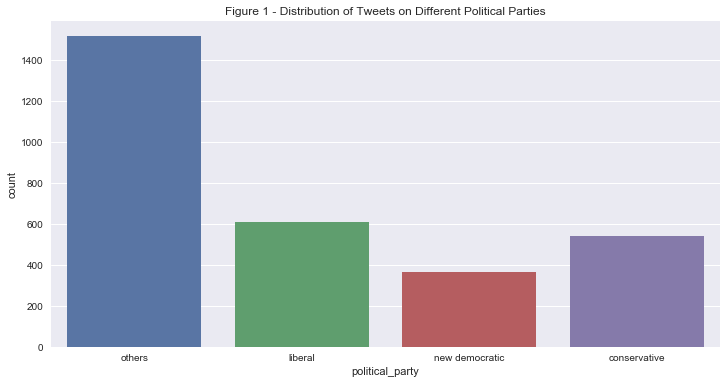

In [11]:
# Visualize the number of tweets talking about each political party
plt.figure(figsize=(12,6))
sns.countplot(x='political_party', data=unclassified)
plt.title('Figure 1 - Distribution of Tweets on Different Political Parties')
plt.show()

#### Produce word clouds for the classified tweets

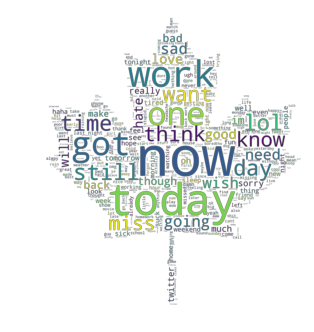

In [12]:
# Produce a word cloud of the negative tweets in the classified file
imageMask = np.array(Image.open('maple.png'))

wc = WordCloud(scale=4, background_color=None, max_words=500, mask=imageMask, mode = 'RGBA')
wc.generate(" ".join(classified[classified['class'] == 0]['text']))

image_colors = ImageColorGenerator(imageMask)

figure = plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("word" + "_cloud" + "_negative" + ".png")

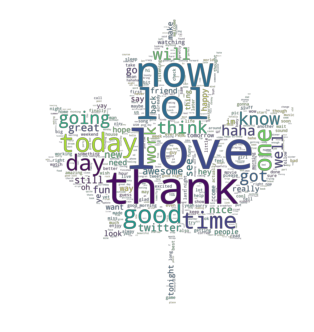

In [13]:
# Produce a word cloud of the positive tweets in the classified file
wc = WordCloud(scale=4, background_color=None, max_words=500, mask=imageMask, mode = 'RGBA')
wc.generate(" ".join(classified[classified['class'] == 4]['text']))

image_colors = ImageColorGenerator(imageMask)

figure = plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("word" + "_cloud" + "_positive" + ".png")

### 3. Model Preparation

In [14]:
# Split the classified data into training and testing sets
X = classified['text'].values.astype('U')
y = classified['class'].values.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [15]:
# Vectorize the features into n grams
#stop_words = pd.read_table('stop_words.txt', names=['word']).values.tolist()
bag_of_words = CountVectorizer(ngram_range=(1,2)) # Did not use stop_words.txt as the stopword list because they are already taken out from the features

In [16]:
# Prepare features into bag of words
X_train_BOW = bag_of_words.fit_transform(X_train)
X_test_BOW = bag_of_words.transform(X_test)

### 4. Model Implementation

#### Train a logistic regression model on the training data and apply the model to the test data to obtain an accuracy value

In [17]:
lg = LogisticRegression()
model = lg.fit(X_train_BOW, y_train)

predictions = model.predict(X_test_BOW)

TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)
print ("This logistic regression model got an accuracy of {}% on the testing set".format(round(ACC*100, 2)))

This logistic regression model got an accuracy of 80.11% on the testing set


#### Apply the model to the unclassified tweets

In [18]:
# Predict the sentiments of the unclassified tweets
X_BOW = bag_of_words.transform(unclassified['text'].values.astype('U'))
sentiments = model.predict(X_BOW)
unclassified['sentiment'] = sentiments
unclassified.head()

,text,splitted_words,stripped_text,hashtag,political_party,sentiment
0,living the dream. #cameraman #camera #camerace...,"[living, the, dream., #cameraman, #camera, #ca...","[living, dream, cameraman, camera, cameracepti...","[cameraman, camera, cameraception, camera, cam...",others,4
1,justin #trudeau's reasons for thanksgiving. to...,"[justin, #trudeau's, reasons, for, thanksgivin...","[justin, trudeaus, reasons, thanksgiving, toda...","[trudeau's, elxn42, quebec, montreal]",liberal,4
2,@themadape butt…..butt…..we’re allergic to l...,"[@themadape, butt…..butt…..we’re, allergic, to...","[themadape, butt butt we’re, allergic, latex, ...","[nbpoli, cdnpoli]",others,0
3,2 massive explosions at peace march in #turkey...,"[2, massive, explosions, at, peace, march, in,...","[2, massive, explosions, peace, march, turkey,...","[turkey., cdnpoli]",others,0
4,#mulcair suggests there’s bad blood between hi...,"[#mulcair, suggests, there’s, bad, blood, betw...","[mulcair, suggests, there’s, bad, blood, trude...","[mulcair, trudeau, ready4change, ndp]",new democratic,0


In [19]:
# For each political party count the number of tweets that are positive/negative
unclassified.groupby(['political_party', 'sentiment'])['text'].size()

political_party  sentiment
conservative     0             164
                 4             377
liberal          0             147
                 4             462
new democratic   0              97
                 4             265
others           0             191
                 4            1323
dtype: int64

#### Visualize the classification results

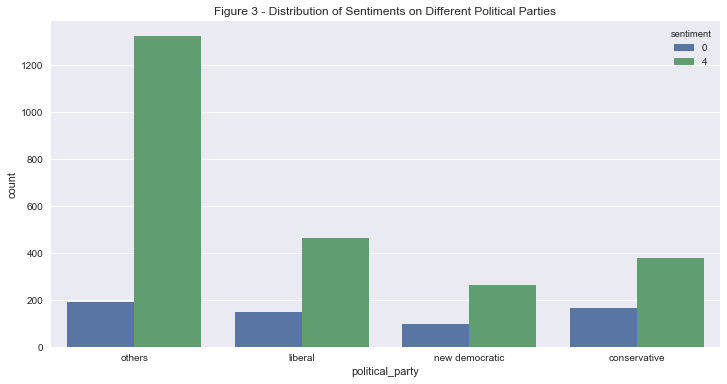

In [20]:
# Visualize the proportion of positive and negative tweets for each party
plt.figure(figsize=(12,6))
sns.countplot(x='political_party', hue='sentiment', data=unclassified)
plt.title('Figure 3 - Distribution of Sentiments on Different Political Parties')
plt.show()

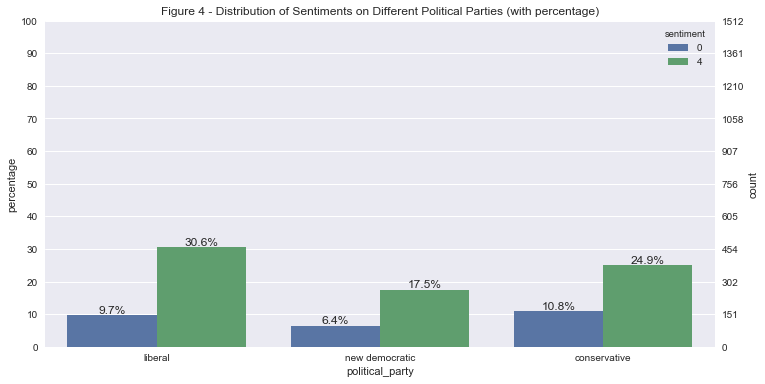

In [21]:
# Label the proportion of tweets that are positive or negtive about the three main parties
df = unclassified[unclassified['political_party']!='others']
ncount = df.shape[0]

plt.figure(figsize=(12,6))
ax = sns.countplot(x='political_party', hue='sentiment', data=df)
plt.title('Figure 4 - Distribution of Sentiments on Different Political Parties (with percentage)')

# Make twin axis
ax2 = ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('percentage')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the percentage range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# Use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

plt.show()

#### Visualise the positive and negative tweets in word cloud

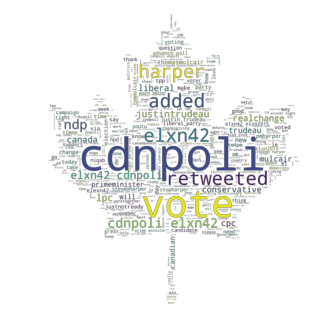

In [22]:
# Produce a word cloud of the negative tweets in the classified file
wc = WordCloud(scale=4, background_color=None, max_words=500, mask=imageMask, mode = 'RGBA')
wc.generate(" ".join(unclassified[unclassified['sentiment'] == 4]['text']))

image_colors = ImageColorGenerator(imageMask)

figure = plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("word" + "_cloud" + "_negative1" + ".png")

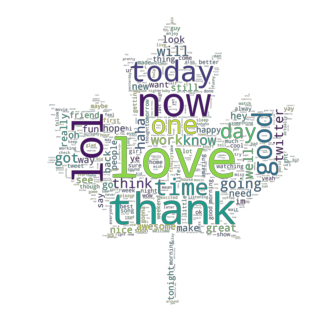

In [23]:
# Produce a word cloud of the positive tweets in the classified file
wc = WordCloud(scale=4, background_color=None, max_words=500, mask=imageMask, mode = 'RGBA')
wc.generate(" ".join(classified[classified['class'] == 4]['text']))

image_colors = ImageColorGenerator(imageMask)

figure = plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
wc.to_file("word" + "_cloud" + "_positive1" + ".png")

We can see that the positive tweets in the classified file and the positive tweets in the unclassified file have some thing in common: they both contain words like "lol", "love", "thank" more often.

### 5. Discussion

From Figure 1, we can see that the Liberal Party draws more attention than the other two as there are more tweets about it. 
In Figure 4, for each political party, there are more positive tweets than negative ones. The Liberal Party has more positive tweets than the other two. This shows a public preference of the Liberal Party. 24.9% of all tweets collected are positive about the Conservative Party, which is also a high percentage. However, there are 10.8% negative about the Conservative Party, which might mean that it is controversial to the public. The New Democratic Party has nearly 2 times more positive tweets than the negative ones. This means people are generally positive about them.
We can conclude from the analysis that the public pay closer attention to and is in preference of the Liberal Party. We might be able to say that more people would vote for the Liberal Party.

The real result was that the Liberal Party won 184 seats, allowing it to form a majority government with Trudeau becoming the next Prime Minister (Wikipedia). This is aligned with the analysis result we got from the logistic regression model.

Although the model is reliable according to the real election result, there are still things to do to improve its performance. If the training set is not evenly split into postive tweets and negative tweets (e.g. there are a lot of positive tweets, only several negative ones), the model would be biased. This can be solved by k-fold cross validation. Also, the input features of the model are 2-grams, which might not be optimal. We may also want to try other classifiers such as Naive Bayes. We can tune the hyper parameters to improve the performance and reduce the degree of overfitting.

### Bonus

#### Tune the hyperparameters to improve the performance of the logistic regression model

In [24]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression()),
])
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__C': (10, 1, 0.01),
    #'clf__penalty': ('l2', 'elasticnet'),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=10, verbose=1) # 10 folds would take a while

X = classified['text'].astype('U').tolist()
y = classified['class'].astype('int').tolist()
grid_search.fit(X, y)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.6min finished


Best score: 0.796
Best parameters set:
	clf__C: 1
	vect__ngram_range: (1, 2)


Now we know that bigrams are better than unigrams for this particular model. 1 is the optimal value for the hyper parameter C among {10, 1, 0.01}. The accuracy here is slightly lower than that of the logistic regression result above. This is because GridSearchCV runs with cross validation and gives a more reliable accuracy.

#### Train a Multinomial Naive Bayes model

In [25]:
mnb = MultinomialNB()
model = mnb.fit(X_train_BOW, y_train)

predictions = model.predict(X_test_BOW)

TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)
print("This multinomial Naive Bayes model got an accuracy of {}% on the testing set".format(round(ACC*100, 2)))

This multinomial Naive Bayes model got an accuracy of 78.09% on the testing set


In [26]:
sentiments = model.predict(X_BOW)
unclassified['sentiment'] = sentiments
unclassified.head()

,text,splitted_words,stripped_text,hashtag,political_party,sentiment
0,living the dream. #cameraman #camera #camerace...,"[living, the, dream., #cameraman, #camera, #ca...","[living, dream, cameraman, camera, cameracepti...","[cameraman, camera, cameraception, camera, cam...",others,0
1,justin #trudeau's reasons for thanksgiving. to...,"[justin, #trudeau's, reasons, for, thanksgivin...","[justin, trudeaus, reasons, thanksgiving, toda...","[trudeau's, elxn42, quebec, montreal]",liberal,4
2,@themadape butt…..butt…..we’re allergic to l...,"[@themadape, butt…..butt…..we’re, allergic, to...","[themadape, butt butt we’re, allergic, latex, ...","[nbpoli, cdnpoli]",others,0
3,2 massive explosions at peace march in #turkey...,"[2, massive, explosions, at, peace, march, in,...","[2, massive, explosions, peace, march, turkey,...","[turkey., cdnpoli]",others,0
4,#mulcair suggests there’s bad blood between hi...,"[#mulcair, suggests, there’s, bad, blood, betw...","[mulcair, suggests, there’s, bad, blood, trude...","[mulcair, trudeau, ready4change, ndp]",new democratic,0


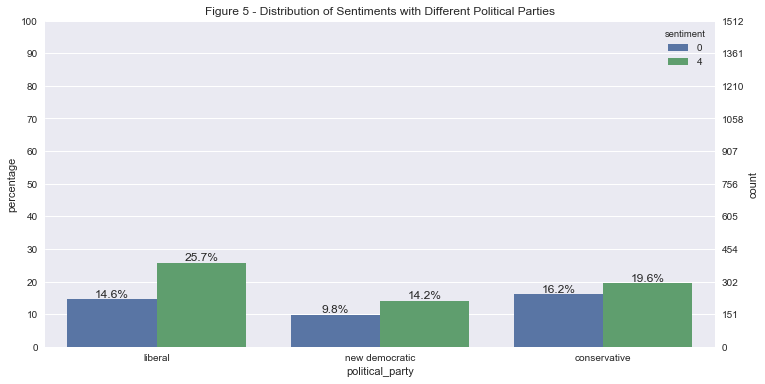

In [27]:
# Visualize the proportion of positive and negative tweets for each party
df = unclassified[unclassified['political_party']!='others']
ncount = df.shape[0]

plt.figure(figsize=(12,6))
ax = sns.countplot(x='political_party', hue='sentiment', data=df)
plt.title('Figure 5 - Distribution of Sentiments with Different Political Parties')

# Make twin axis
ax2 = ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('percentage')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the percentage range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# Use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

plt.show()

The Multinomial Naive Bayes classifier gives a similar result to the Logistic Regression one. The Liberal Party still has the most number of tweets positive about them. However, the Naive Bayes model classifies more tweets as negative for every party. If we look at the Conservative Party, although it draws a lot of public attention, there are nearly equal number of negative tweets and positive tweets about it. In this case, it is hard to tell if people are happy with the Conservative Party or not with the data we have.